# Bitcoin Price Prediction with TensorFlow: Example Notebook

This notebook demonstrates how to use the utility functions from `bitcoin_utils.py` to:
- Load and clean historical Bitcoin data.
- Engineer technical features.
- Prepare sequences for LSTM modeling.
- Train a simple LSTM network to predict Bitcoin prices.

We keep this example minimal and clean to illustrate usage of the provided API.


### Setup & Imports

In [15]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

# Imports
import sys
sys.path.append("..")  # if needed to import bitcoin_utils.py

import numpy as np
import matplotlib.pyplot as plt

from bitcoin_utils import (
    load_and_clean_csv,
    update_dataset_with_latest,
    technical_features,
    generate_sequences,
    build_lstm_model,
    train_lstm_model,
    fine_tune_model,
    plot_training_loss,
    predict_next_price,
    tune_lstm_model,
    evaluate_predictions,
    plot_actual_vs_predicted

)


## Load and Clean Bitcoin Data

We load the dataset from the CSV file and apply initial cleaning and formatting.


In [16]:
# Path to your dataset
csv_path = 'btc-usd-max.csv'  # Update path if needed

# Load and clean
df = load_and_clean_csv(csv_path)

# Show the head
df.head()


INFO:bitcoin_utils:Loading dataset from btc-usd-max.csv
INFO:bitcoin_utils:Removed 98 anomalous rows based on z-score > 3.0
INFO:bitcoin_utils:Dataset loaded: 4306 rows; columns: ['price', 'market_cap', 'total_volume']


,price,market_cap,total_volume
snapped_at,,,
2013-04-28 00:00:00+00:00,135.30,1.500518e+09,0.0
2013-04-29 00:00:00+00:00,141.96,1.575032e+09,0.0
2013-04-30 00:00:00+00:00,135.30,1.501657e+09,0.0
2013-05-01 00:00:00+00:00,117.00,1.298952e+09,0.0
2013-05-02 00:00:00+00:00,103.43,1.148668e+09,0.0


## Update Dataset with Latest Data Point

To ensure we are working with the most recent Bitcoin data, we can use the `update_dataset_with_latest()` function from `bitcoin_utils.py`.

This function:
- Fetches the latest market data from the CoinGecko API.
- Appends the new data point to the existing dataset (if it’s not already present).
- Keeps your CSV file up-to-date automatically.

We then reload the updated dataset to continue working with the latest data.


In [17]:

update_dataset_with_latest(csv_path)

# Reload the updated dataset
df = load_and_clean_csv(csv_path)

# Confirm update
df.tail()

INFO:bitcoin_utils:Loading existing dataset from btc-usd-max.csv
INFO:bitcoin_utils:Fetching latest data point from CoinGecko
INFO:bitcoin_utils:Latest data point: {'snapped_at': Timestamp('2025-05-18 03:48:23+0000', tz='UTC'), 'price': 103298.75852771972, 'market_cap': 2052012393370.1504, 'total_volume': 16828383423.789356}
INFO:bitcoin_utils:Appending new data point to the dataset.
INFO:bitcoin_utils:Dataset updated and saved to btc-usd-max.csv
INFO:bitcoin_utils:Loading dataset from btc-usd-max.csv
INFO:bitcoin_utils:Removed 99 anomalous rows based on z-score > 3.0
INFO:bitcoin_utils:Dataset loaded: 4306 rows; columns: ['price', 'market_cap', 'total_volume']


,price,market_cap,total_volume
snapped_at,,,
2025-04-27 00:00:00+00:00,94644.066371,1.879132e+12,1.544539e+10
2025-04-28 00:00:00+00:00,93809.337820,1.862772e+12,1.592626e+10
2025-04-29 00:00:00+00:00,95030.606455,1.887067e+12,3.191381e+10
2025-04-30 00:00:00+00:00,94256.359463,1.870818e+12,2.588263e+10
2025-05-01 00:00:00+00:00,94235.753310,1.871350e+12,2.654170e+10


# Exploratory Data Analysis (EDA)

In this section, we explore the Bitcoin dataset to understand trends, patterns, and relationships between variables.


1. Line Plot: Bitcoin Price Over Time


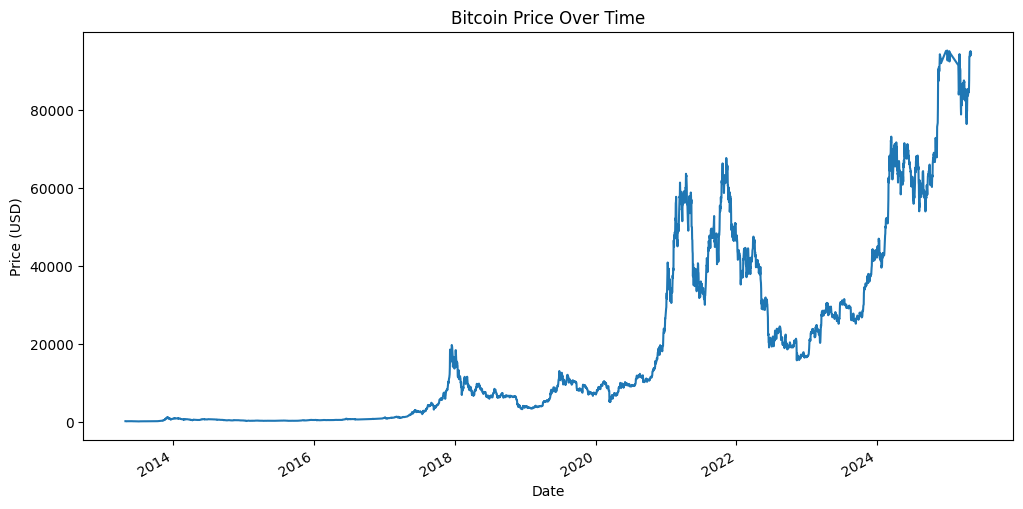

In [18]:
import matplotlib.pyplot as plt

# Plot Bitcoin price over time
plt.figure(figsize=(12,6))
df['price'].plot()
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()


2. Log Scale Price Plot


Bitcoin price spans many orders of magnitude; a log plot can be insightful:


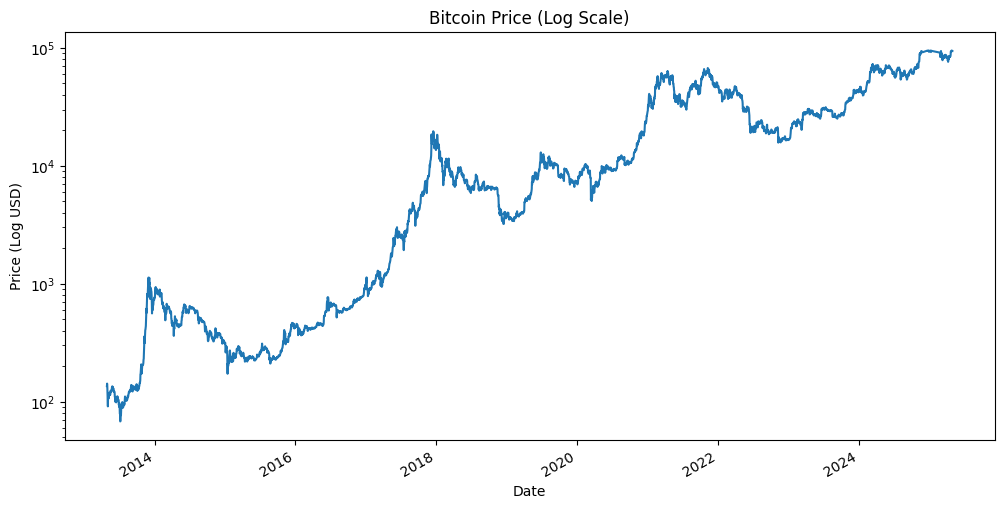

In [19]:
plt.figure(figsize=(12,6))
df['price'].plot(logy=True)
plt.title('Bitcoin Price (Log Scale)')
plt.xlabel('Date')
plt.ylabel('Price (Log USD)')
plt.show()


4. Simple Moving Average (SMA)

You can overlay moving averages to show trends.

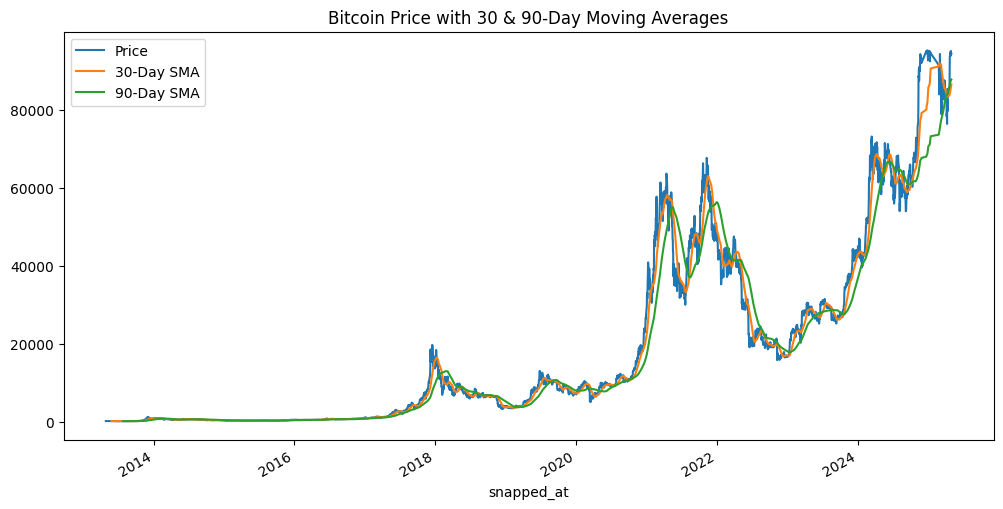

In [21]:
df['SMA_30'] = df['price'].rolling(window=30).mean()
df['SMA_90'] = df['price'].rolling(window=90).mean()

plt.figure(figsize=(12,6))
df['price'].plot(label='Price')
df['SMA_30'].plot(label='30-Day SMA')
df['SMA_90'].plot(label='90-Day SMA')
plt.title('Bitcoin Price with 30 & 90-Day Moving Averages')
plt.legend()
plt.show()


## Feature Engineering

We enrich the dataset with useful features like returns, moving averages, and lag features.


In [22]:
# Add engineered features
df = technical_features(df)
features = [
    'price', 'returns', 'SMA_7', 'SMA_30', 'volatility_7', 'volatility_30',
    'lag_1day', 'RSI_14', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower'
]
X, y, scaler_X, scaler_y = generate_sequences(df, features=features, target='price', window_size=60)


# Now safely generate sequences


print("X shape:", X.shape)
print("y shape:", y.shape)
print("Any NaN in X?", np.isnan(X).any())
print("Any NaN in y?", np.isnan(y).any())
print("X min/max:", X.min(), X.max())
print("y min/max:", y.min(), y.max())


# Drop rows with NaNs in any input feature or the target
df = df.dropna(subset=features + ['price'])
# Check the result
df.tail()

INFO:bitcoin_utils:Adding extended technical features...
INFO:bitcoin_utils:Technical feature engineering complete.
INFO:bitcoin_utils:Generating sequences using features ['price', 'returns', 'SMA_7', 'SMA_30', 'volatility_7', 'volatility_30', 'lag_1day', 'RSI_14', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower'] and target 'price'
INFO:bitcoin_utils:Generated 4246 sequences with shape (60, 12)


X shape: (4246, 60, 12)
y shape: (4246, 1)
Any NaN in X? True
Any NaN in y? False
X min/max: nan nan
y min/max: 0.0 1.0


,price,market_cap,total_volume,SMA_30,SMA_90,returns,SMA_7,volatility_7,volatility_30,lag_1day,RSI_14,MACD,MACD_signal,BB_upper,BB_lower
snapped_at,,,,,,,,,,,,,,,
2025-04-27 00:00:00+00:00,94644.066371,1.879132e+12,1.544539e+10,84944.749173,87243.326878,-0.001362,91856.689034,3910.916209,4735.202649,94773.112006,79.477496,2738.278784,1455.085103,96779.780057,75204.818407
2025-04-28 00:00:00+00:00,93809.337820,1.862772e+12,1.592626e+10,85259.744795,87434.205895,-0.008820,93104.713659,2538.545528,5001.737256,94644.066371,84.093632,2839.206967,1731.909476,97550.118314,75897.484705
2025-04-29 00:00:00+00:00,95030.606455,1.887067e+12,3.191381e+10,85671.459258,87596.026893,0.013019,94187.365011,607.832944,5282.466157,93809.337820,84.404715,2983.349259,1982.197432,97920.805389,77396.949240
2025-04-30 00:00:00+00:00,94256.359463,1.870818e+12,2.588263e+10,86068.125203,87658.459554,-0.008147,94284.535522,544.956639,5468.465915,95030.606455,84.920318,3000.519679,2185.861882,98618.698175,77862.475371
2025-05-01 00:00:00+00:00,94235.753310,1.871350e+12,2.654170e+10,86458.847192,87724.805705,-0.000219,94374.578522,459.408665,5622.364710,94256.359463,84.342295,2978.134535,2344.316412,98835.868769,79109.244376


In [23]:
# Generate sequences for modeling
X, y, scaler_X, scaler_y = generate_sequences(df, features=features, target='price', window_size=60)

INFO:bitcoin_utils:Generating sequences using features ['price', 'returns', 'SMA_7', 'SMA_30', 'volatility_7', 'volatility_30', 'lag_1day', 'RSI_14', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower'] and target 'price'
INFO:bitcoin_utils:Generated 4217 sequences with shape (60, 12)


## Build LSTM Model

We build a simple LSTM model to predict Bitcoin prices based on historical data.


While the project documentation refers to an RNN architecture broadly, we chose to implement an LSTM (Long Short-Term Memory) model — a more advanced form of RNN — to better capture long-term dependencies in Bitcoin price trends. LSTM networks are specifically designed to overcome the vanishing gradient problem, making them highly effective for financial time series forecasting.


In [24]:
# Split data into train/test sets (e.g., 80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


## Hyperparameter Tuning with KerasTuner

We use the `tune_lstm_model()` utility to search for the best:
- Number of LSTM units in each layer
- Dropout rates
- Validation loss over multiple trials

This keeps the notebook clean while allowing reproducible tuning.

In [25]:
# Tune hyperparameters
best_model, best_hps, history = tune_lstm_model(X_train, y_train, X_test, y_test)


INFO:tensorflow:Oracle triggered exit


Trial 5 Complete [00h 00m 38s]
val_loss: 0.0008546360186301172

Best val_loss So Far: 0.0008546360186301172
Total elapsed time: 00h 03m 18s
Epoch 1/20
106/106 [==============================] - 5s 35ms/step - loss: 7.4391e-04 - val_loss: 0.0032
Epoch 2/20
106/106 [==============================] - 3s 32ms/step - loss: 7.4027e-04 - val_loss: 0.0027
Epoch 3/20
106/106 [==============================] - 3s 31ms/step - loss: 8.1505e-04 - val_loss: 0.0014
Epoch 4/20
106/106 [==============================] - 3s 31ms/step - loss: 6.7942e-04 - val_loss: 0.0013
Epoch 5/20
106/106 [==============================] - 3s 31ms/step - loss: 7.0436e-04 - val_loss: 0.0088
Epoch 6/20
106/106 [==============================] - 5s 48ms/step - loss: 6.6129e-04 - val_loss: 0.0017
Epoch 7/20
106/106 [==============================] - 3s 32ms/step - loss: 6.3569e-04 - val_loss: 7.0184e-04
Epoch 8/20
106/106 [==============================] - 3s 32ms/step - loss: 6.4770e-04 - val_loss: 0.0030
Epoch 9/20
106/1

In [26]:
print("Best Hyperparameters Found:")
print(f"LSTM Layer 1 Units: {best_hps.get('lstm_units_1')}")
print(f"Dropout Layer 1: {best_hps.get('dropout_1')}")
print(f"LSTM Layer 2 Units: {best_hps.get('lstm_units_2')}")
print(f"Dropout Layer 2: {best_hps.get('dropout_2')}")


Best Hyperparameters Found:
LSTM Layer 1 Units: 96
Dropout Layer 1: 0.1
LSTM Layer 2 Units: 64
Dropout Layer 2: 0.4


## Train LSTM Model


In [27]:
model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model, history = train_lstm_model(model, X_train, y_train, X_test, y_test)
#  Save the model so the scheduler can fine-tune and predict with it
model.save("models/final_lstm_model.h5")

INFO:bitcoin_utils:Building LSTM model with input shape (60, 12)
INFO:bitcoin_utils:Training LSTM model for 50 epochs with batch size 32


Epoch 1/50
106/106 [==============================] - 6s 40ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 2/50
106/106 [==============================] - 4s 36ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 3/50
106/106 [==============================] - 4s 35ms/step - loss: 8.8624e-04 - val_loss: 0.0037
Epoch 4/50
106/106 [==============================] - 6s 54ms/step - loss: 8.5237e-04 - val_loss: 9.3191e-04
Epoch 5/50
106/106 [==============================] - 4s 35ms/step - loss: 7.8512e-04 - val_loss: 0.0063
Epoch 6/50
106/106 [==============================] - 4s 35ms/step - loss: 7.0016e-04 - val_loss: 0.0011
Epoch 7/50
106/106 [==============================] - 4s 35ms/step - loss: 6.2768e-04 - val_loss: 8.4777e-04
Epoch 8/50
106/106 [==============================] - 4s 35ms/step - loss: 6.5904e-04 - val_loss: 8.7037e-04
Epoch 9/50
106/106 [==============================] - 4s 35ms/step - loss: 6.0123e-04 - val_loss: 0.0040
Epoch 10/50
106/106 [==============================

INFO:bitcoin_utils:Model training complete.
/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Visualize Model Performance

We plot the training and validation loss to observe how the model learns.


INFO:bitcoin_utils:Plotting training and validation loss.


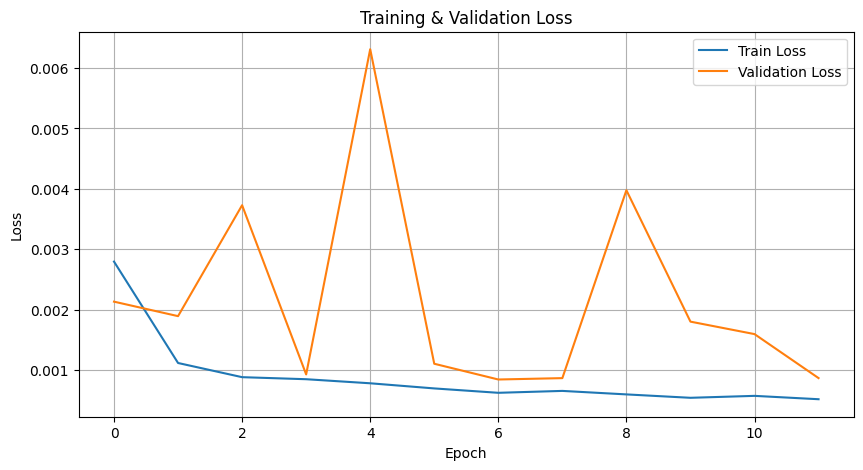

In [28]:
plot_training_loss(history)

INFO:bitcoin_utils:Predicting next Bitcoin price using latest sequence...


1/1 [==============================] - 0s 343ms/step


INFO:bitcoin_utils:Plotting recent prices with prediction...


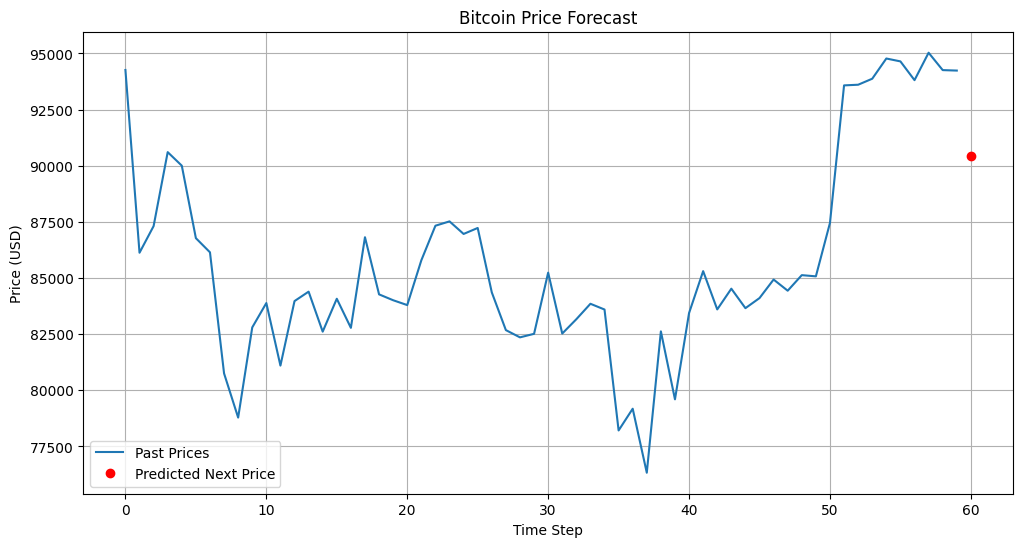

INFO:bitcoin_utils:Predicted price: $90,427.02


📈 Predicted Next Price: $90,427.02


In [29]:
# Prepare last input
X_input = X[-1:].copy()
recent_prices = df['price'].iloc[-60:].values

# Predict and plot
predicted_price = predict_next_price(model, X_input, scaler_y, recent_prices, plot=True)
print(f"📈 Predicted Next Price: ${predicted_price:,.2f}")


27/27 [==============================] - 0s 12ms/step


INFO:bitcoin_utils:Evaluating model predictions...
INFO:bitcoin_utils:MAE: 1864.58, RMSE: 2769.47


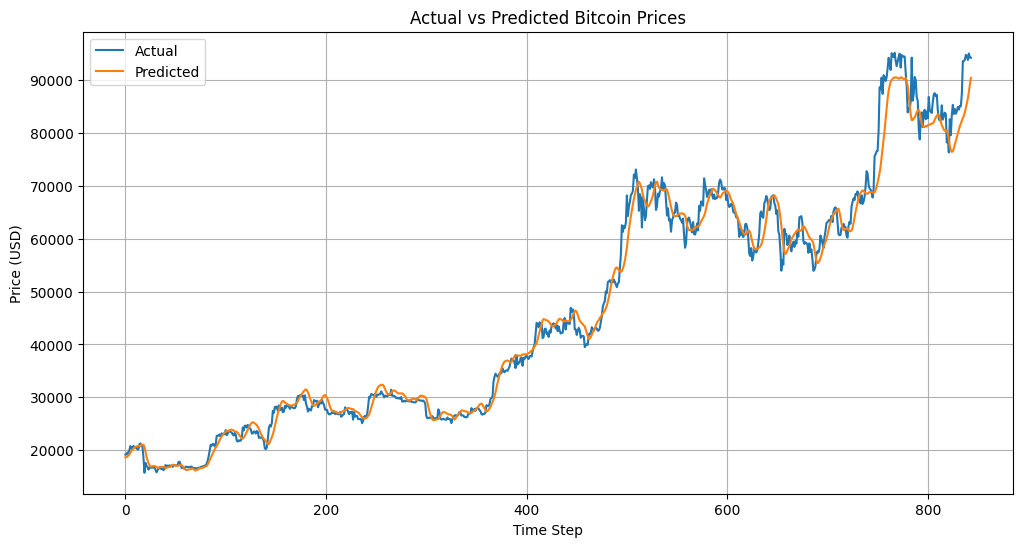

 Evaluation Metrics: {'MAE': 1864.5804920201613, 'RMSE': 2769.465518158654}


In [30]:
# Predict on test set
y_pred_scaled = model.predict(X_test)

# Evaluate and plot
metrics = evaluate_predictions(y_test, y_pred_scaled, scaler_y, plot=True)
print(" Evaluation Metrics:", metrics)
